# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

In [3]:
!pip install stop_words

## Librerias

In [36]:
import datetime
import joblib
import numpy as np
import pandas as pd
import spacy
import stop_words

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

## Conjuntos

In [37]:
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

In [7]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

NameError: name 'X_train' is not defined

## Lemmarizacion

In [8]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

# 1. Bayes Naïve

## Importaciones

In [3]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [4]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

nb_old_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

### Vect_1

In [5]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.887126


### Vect_2

In [6]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.883519


### Vect_3

In [7]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.877547


### Vect_4

In [8]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874018


### Mejor Vect

In [9]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.887126,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.883519,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.877547,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874018,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [10]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.887126 {'min_df': 2, 'ngram_range': (1, 3)} False TFIDF


In [11]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [12]:
param_distributions = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'], best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.25}
Mejor F1 Score (afinados): 0.8869158442969984


In [13]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8882572044697118


## Conjunto test

In [14]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [53]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve{current_date}.csv", index=False)

In [54]:
joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

['Modelos/bn_model_2024-05-31.joblib']

# 2. Random Forest

## Importaciones

In [25]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [43]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

rf_old_model = joblib.load('Modelos/rf_model_2024-05-28.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [44]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

{'min_df': 1, 'ngram_range': (1, 2)}
{'min_df': 1, 'ngram_range': (1, 3)}
{'min_df': 1, 'ngram_range': (1, 4)}
{'min_df': 2, 'ngram_range': (1, 2)}
{'min_df': 2, 'ngram_range': (1, 3)}
{'min_df': 2, 'ngram_range': (1, 4)}
{'min_df': 3, 'ngram_range': (1, 2)}
{'min_df': 3, 'ngram_range': (1, 3)}
{'min_df': 3, 'ngram_range': (1, 4)}
{'min_df': 4, 'ngram_range': (1, 2)}
{'min_df': 4, 'ngram_range': (1, 3)}
{'min_df': 4, 'ngram_range': (1, 4)}
{'min_df': 5, 'ngram_range': (1, 2)}
{'min_df': 5, 'ngram_range': (1, 3)}
{'min_df': 5, 'ngram_range': (1, 4)}
{'min_df': 8, 'ngram_range': (1, 2)}
{'min_df': 8, 'ngram_range': (1, 3)}
{'min_df': 8, 'ngram_range': (1, 4)}
{'min_df': 10, 'ngram_range': (1, 2)}
{'min_df': 10, 'ngram_range': (1, 3)}
{'min_df': 10, 'ngram_range': (1, 4)}
{'min_df': 15, 'ngram_range': (1, 2)}
{'min_df': 15, 'ngram_range': (1, 3)}
{'min_df': 15, 'ngram_range': (1, 4)}
Mejor config Vect_1 : {'min_df': 8, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_1 : 0.800898


### Vect_2

In [45]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 4, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_2 : 0.802835


### Vect_3

In [46]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 8, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.803253


### Vect_4

In [47]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 8, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.798421


### Mejor Vect

In [48]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.800898,"{'min_df': 8, 'ngram_range': (1, 4)}",False,TFIDF
1,0.802835,"{'min_df': 4, 'ngram_range': (1, 2)}",True,TFIDF
2,0.803253,"{'min_df': 8, 'ngram_range': (1, 2)}",False,Count
3,0.798421,"{'min_df': 8, 'ngram_range': (1, 4)}",True,Count


In [49]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.803253 {'min_df': 8, 'ngram_range': (1, 2)} False Count


In [50]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [60]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base

Mejores parametros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6, 'criterion': 'gini'}
Mejor F1 Score: 0.8254578248430569


In [61]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8327905461989392


In [62]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-02.joblib']

## Conjunto test

In [63]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [64]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Vectorizacion de las críticas : sin lemmarizacion

In [18]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stop_words_es = stop_words.get_stop_words('es')
vectorizer = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

## Busqueda de los hiperparametros

In [19]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size = int(0.1 * X_train_vect.shape[0])
sample_indices = np.random.choice(X_train_vect.shape[0], size=sample_size, replace=False)
X_train_sampled = X_train_vect[sample_indices]
y_train_sampled = y_train.iloc[sample_indices]

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_sampled, y_train_sampled)

In [ ]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

In [ ]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

## Conjunto test

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vectorizer.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

## Exportaciones

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

## Vectorizacion de las críticas : con lemmarizacion

In [ ]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
print(X_train_processed)

vectorizer_lemma = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect_lemma = vectorizer_lemma.fit_transform(X_train_processed)
X_test_vect_lemma = vectorizer_lemma.transform(X_test)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size_lemma = int(0.1 * X_train_vect_lemma.shape[0])
sample_indices_lemma = np.random.choice(X_train_vect_lemma.shape[0], size=sample_size_lemma, replace=False)
X_train_sampled_lemma = X_train_vect_lemma[sample_indices_lemma]
y_train_sampled_lemma = y_train.iloc[sample_indices_lemma]

random_search_lemma = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search_lemma.fit(X_train_sampled_lemma, y_train_sampled_lemma)

best_params = random_search_lemma.best_params_
best_score = random_search_lemma.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_xgb_model_lemma = random_search_lemma.best_estimator_
best_xgb_model_lemma.fit(X_train_vect_lemma, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect_lemma, y_test)])
y_pred_lemma = best_xgb_model.predict(X_test_vect_lemma)

f1_lemma = f1_score(y_test, y_pred_lemma)
print(f'F1 Score: {f1_lemma}')

current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search_lemma, f'Modelos/xgb_model_lemmatizacion_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model_lemma, f'Modelos/xgb_model_lemmatizacion_{current_date}.joblib')

conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test_lemma = vectorizer_lemma.transform(conjunto_test['review_es'])

pred_test_lemma = best_xgb_model_lemma.predict(X_conjunto_test_lemma)
pred_test_labels_lemma = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemma]

final_pred_df_lemma = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels_lemma
})

final_pred_df_lemma.to_csv(f"Predicciones/XGBoost_lemmatizacion_{current_date}.csv", index=False)

# 4. Red Neuronal aplicando Keras y Tensor Flow

In [38]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

In [39]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import backend as K
from keras.layers import Dense, TextVectorization, LSTM, Conv1D, Reshape
from keras.optimizers import Adadelta
from keras.regularizers import l2
import seaborn as sns
import matplotlib.pyplot as plt

X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))

# vectorizacion de los datos en el modelo directamente
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=20000)
vectorizer.adapt(X_train_list)

In [40]:
modelo = Sequential([
    vectorizer,
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))])

modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 20000)            1         
 ectorization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 20001     
                                                                 
Total params: 20,002
Trainable params: 20,001
Non-trainable params: 1
_________________________________________________________________


In [41]:
def f1_score_manual(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

modelo.compile(
  optimizer=Adadelta(learning_rate=0.1,
                        rho=0.95,
                        epsilon=1e-07),
  loss='binary_crossentropy',
  metrics=[f1_score_manual],
)

In [42]:
X_train_array = np.array(X_train_list)
X_test_array = np.array(X_test_list)

cant_epochs=100
modelo_fit = modelo.fit(X_train_array, y_train, epochs=cant_epochs, batch_size=50, verbose=False)

In [43]:
y_predic = modelo.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)
y_pred_series

313/313 [==============================] - 2s 5ms/step


33553    0
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Length: 10000, dtype: int32

In [45]:
f1_score_modelo = f1_score(y_test, y_pred_series)
print(f1_score_modelo)

0.8819326941154352


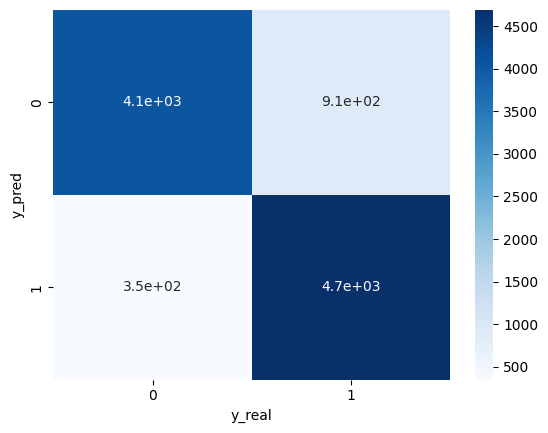

In [46]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [52]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test)
X_conjunto_test_array

array(['La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines a ver este producto patrocinado por Tele 5. Esa jun

In [53]:
y_predic = modelo.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 [==============================] - 2s 6ms/step


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [56]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

modelo.save(f'Modelos/red_neuronal_{current_date}')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_{current_date}.csv", index=False)

INFO:tensorflow:Assets written to: Modelos/red_neuronal_2024-06-04\assets


# 5. Ensamble de 3 modelos (o mas)